In [1]:
import findspark
import pandas as pd
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf

# for shared metastore (shared across all users)
spark = SparkSession.builder.appName("List available databases and tables").config("hive.metastore.uris", "thrift://bialobog:9083", conf=SparkConf()).getOrCreate() \

# for local metastore (your private, invidivual database) add the following config to spark session

spark.catalog.listDatabases()

[Database(name='2022_10_22', catalog='spark_catalog', description='FactSet data version for the day', locationUri='hdfs://bialobog.cs.ucl.ac.uk:8020/user/hive/warehouse'),
 Database(name='2023_04_01', catalog='spark_catalog', description='FactSet data version for the day', locationUri='hdfs://bialobog.cs.ucl.ac.uk:8020/user/hive/warehouse'),
 Database(name='default', catalog='spark_catalog', description='Default Hive database', locationUri='hdfs://bialobog.cs.ucl.ac.uk:8020/user/hive/warehouse')]

In [2]:
spark.sql("SHOW TABLES IN 2023_04_01").show(10)

+----------+--------------------+-----------+
| namespace|           tableName|isTemporary|
+----------+--------------------+-----------+
|2023_04_01|  affiliate_type_map|      false|
|2023_04_01|     asset_class_map|      false|
|2023_04_01|      audit_type_map|      false|
|2023_04_01|ca_div_freq_qual_map|      false|
|2023_04_01|     ca_div_type_map|      false|
|2023_04_01|   ca_event_type_map|      false|
|2023_04_01| ce_audio_source_map|      false|
|2023_04_01|   ce_event_type_map|      false|
|2023_04_01|ce_fiscal_period_map|      false|
|2023_04_01|  ce_market_time_map|      false|
+----------+--------------------+-----------+
only showing top 10 rows



In [3]:
imploded_stocks = pd.read_csv('filtered_tickers.csv')
imploded_stocks = imploded_stocks['Ticker'].tolist()
sp500_stocks = pd.read_csv('spx500.csv', usecols=['Symbol'])
sp500_stocks = sp500_stocks['Symbol'].tolist()

In [4]:
import random

random_seed = 42
random.seed(random_seed)
combined_stocks = imploded_stocks + sp500_stocks
#random.shuffle(combined_stocks)
combined_stocks = sorted(combined_stocks)


In [5]:
import yfinance as yf
from datetime import datetime

def pull_stock_monthly(stock_list, start_date='2009-01-01', end_date=datetime.now().strftime('%Y-%m-%d')):
    all_series = []
    for t in stock_list:
        df = yf.download(t, start=start_date, end=end_date, progress=False)
        if not(df.empty):
            monthly_df = df['Adj Close'].resample('M').last().to_frame()
            monthly_df['Ticker'] = t
            all_series.append(monthly_df)
    combined_df = pd.concat(all_series, axis=0)
    combined_df.to_csv('imploded_only.csv')
        

#pull_stock_monthly(imploded_stocks)
#with (filtered) imploded stocks and sp500 stocks the total number of rows of data is 134,523 (monthly)

In [37]:
import os
def get_data(filename):
    pandas_df = pd.read_csv(filename)
    spark_df = spark.createDataFrame(pandas_df)
    spark_df = spark_df.orderBy("Ticker", "Date")
    #spark_df.show(10)
    
    return spark_df

def clean_after_implosions(df):
    cleaned_rows = []
    unique_tickers_df = df.select("Ticker").distinct()
    unique_tickers = [row.Ticker for row in unique_tickers_df.collect()]
    for t in unique_tickers:
        filtered_df = df.filter(df["Ticker"] == t)
        latest_imploded_date = filtered_df.filter(filtered_df['Imploded']==1).agg({"Date": "max"}).collect()[0][0]
        cleaned_rows_for_ticker = filtered_df.filter(filtered_df['Date'] <= latest_imploded_date).collect()
        cleaned_rows.extend(cleaned_rows_for_ticker)
    cleaned_df = spark.createDataFrame(cleaned_rows, schema=df.schema)
    pandas_df = cleaned_df.toPandas()
    pandas_df.to_csv('imploded_cleaned.csv', index=False)
    print(pandas_df.head(100))
        

#task of which stocks vs when stock implodes
#clean_after_implosions(df)

In [7]:
df = get_data('imploded_only.csv')

+----------+---------+------+--------+
|      Date|Adj Close|Ticker|Imploded|
+----------+---------+------+--------+
|2009-01-31|   1125.0|  ABEO|       0|
|2009-02-28|   1750.0|  ABEO|       0|
|2009-03-31|   2062.5|  ABEO|       0|
|2009-04-30|   1875.0|  ABEO|       0|
|2009-05-31|   2312.5|  ABEO|       0|
|2009-06-30|   2812.5|  ABEO|       0|
|2009-07-31|   5625.0|  ABEO|       0|
|2009-08-31|   4762.5|  ABEO|       0|
|2009-09-30|   3562.5|  ABEO|       0|
|2009-10-31|   3750.0|  ABEO|       0|
+----------+---------+------+--------+
only showing top 10 rows



+------+----------+-----------------+--------+
|Ticker|      Date|            Price|Imploded|
+------+----------+-----------------+--------+
|   OCX|2015-12-31|            125.0|       0|
|   OCX|2016-01-31|             83.0|       0|
|   OCX|2016-02-29|76.80000305175781|       0|
|   OCX|2016-03-31| 92.1999969482422|       0|
|   OCX|2016-04-30|103.8000030517578|       0|
|   OCX|2016-05-31|85.19999694824219|       0|
|   OCX|2016-06-30|71.19999694824219|       0|
|   OCX|2016-07-31| 75.4000015258789|       0|
|   OCX|2016-08-31| 77.4000015258789|       0|
|   OCX|2016-09-30|100.8000030517578|       0|
+------+----------+-----------------+--------+
only showing top 10 rows

420


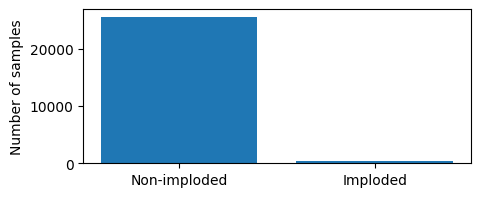

In [9]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

def imploded_vs_normal(df):
    imploded = df.filter(col('Imploded')==1).count()
    normal = df.filter(col('Imploded')==0).count()
    print(imploded)
    plt.figure(figsize=(5,2))
    plt.bar(['Non-imploded', 'Imploded'], [normal, imploded])
    plt.ylabel('Number of samples')
    plt.show()

df = get_data('imploded_cleaned.csv')
imploded_vs_normal(df)

In [41]:
from pyspark.sql import functions as F
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import quarter, expr
from pyspark.sql.functions import col, lit, when, coalesce
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings

# Suppress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

def prev_quarter(date_col):
    return F.when((F.month(date_col) == 1) | (F.month(date_col) == 2) | (F.month(date_col) == 12), 1) \
            .when((F.month(date_col) >= 3) & (F.month(date_col) <= 5), 2) \
            .when((F.month(date_col) >= 6) & (F.month(date_col) <= 8), 3) \
            .otherwise(4)


def reporting_year(date_col):
    return F.when((F.month(date_col) == 1) | (F.month(date_col) == 2), F.year(date_col) - 1) \
            .otherwise(F.year(date_col))

def total_assets(ticker, start_date, end_date):
    spark.sql("USE 2023_04_01")
    # Assuming that 'ticker' is a valid Python variable

    query = f"""SELECT d.ticker_region, a.date, a.ff_assets, a.ff_sales, a.FF_GROSS_INC, a.FF_COM_SHS_OUT, FF_CASH_ST, FF_DEBT, FF_PRICE_CLOSE_FP
                FROM FF_BASIC_QF a 
                LEFT JOIN sym_ticker_region d ON d.fsym_id = a.fsym_id 
                WHERE d.ticker_region = "{ticker}-US" 
                AND a.date >= "{start_date}" AND a.date <= "{end_date}"
                ORDER BY a.date"""

    df = spark.sql(query)
    df = df.withColumnRenamed('ff_assets', 'Total Assets')
    df = df.withColumnRenamed('ff_sales', 'Sales')
    df = df.withColumnRenamed('FF_COM_SHS_OUT', 'Market Val')
    df = df.withColumnRenamed('FF_CASH_ST', 'Cash/Short Term Investments')
    df = df.withColumnRenamed('FF_DEBT', 'Total Debt')
    df = df.withColumnRenamed('FF_GROSS_INC', 'Gross Income')
    df = df.withColumnRenamed('FF_PRICE_CLOSE_FP', 'Share Price')
    df = df.withColumn('Market Val', col('Market Val') * col('Share Price'))
    df = df.withColumn("ticker_region", regexp_replace("ticker_region", "-US$", ""))
    return df

def plot_with_price(spark_df):
    unique_tickers_df = spark_df.select("Ticker").distinct()
    unique_tickers = sorted([row.Ticker for row in unique_tickers_df.collect()])
    for t in unique_tickers:
        print(t)
        filtered_df = spark_df.filter(spark_df["Ticker"] == t)
        start_date = filtered_df.agg({"Date": "min"}).collect()[0][0]
        end_date = filtered_df.agg({"Date": "max"}).collect()[0][0]
        t_df = total_assets(t, start_date, end_date)
        num_cols = 3
        columns = t_df.columns
        columns.remove('date')
        columns.remove('ticker_region')
        num_rows = (len(columns) - 1) // num_cols + 1
        scaler = StandardScaler()
        fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5*num_rows))
        axes = axes.flatten()
        for i, column in enumerate(columns):
            if column != "Share Price" and column != 'ticker_region' and column != 'date':
                # Plot the selected column against the "FF_PRICE_CLOSE_FP"
                normalized_column = scaler.fit_transform(t_df.select(column).collect())
                normalized_price = scaler.fit_transform(t_df.select("Share Price").collect())
                
                axes[i].plot(t_df.select("date").collect(), normalized_column, label=column)
                axes[i].plot(t_df.select("date").collect(), normalized_price, label="Price")

                # Set subplot title
                axes[i].set_title(f"{column} and Price over Time")

                # Set axis labels
                axes[i].set_xlabel("Date")
                axes[i].set_ylabel("Value")

                # Display legend
                axes[i].legend()

        for j in range(len(columns), num_cols * num_rows):
            fig.delaxes(axes[j])

        # Adjust layout to prevent overlapping
        plt.tight_layout()

        # Show the plots
        plt.show()
        

def corr_analysis(spark_df):
    n = 0
    corr_matrices = []
    unique_tickers_df = spark_df.select("Ticker").distinct()
    unique_tickers = [row.Ticker for row in unique_tickers_df.collect()]
    for t in unique_tickers:
        filtered_df = spark_df.filter(spark_df["Ticker"] == t)
        start_date = filtered_df.agg({"Date": "min"}).collect()[0][0]
        end_date = filtered_df.agg({"Date": "max"}).collect()[0][0]
        t_df = total_assets(t, start_date, end_date)
        cm = t_df.toPandas().corr()
        cm = pd.DataFrame(cm)
        if not(cm.isnull().values.any()):
            corr_matrices.append(cm)
            n+=1
    avg_corr_mat = sum(corr_matrices) / len(corr_matrices)
    sns.heatmap(avg_corr_mat, annot=True, cmap='RdYlGn',linewidths=0.2)
    fig=plt.gcf()
    fig.set_size_inches(5,4)
    plt.show()
    print(n, len(unique_tickers))
        
def add_fundamental(spark_df):
    
    unique_tickers_df = spark_df.select("Ticker").distinct()
    unique_tickers = sorted([row.Ticker for row in unique_tickers_df.collect()])
    
    for t in unique_tickers:
        filtered_df = spark_df.filter(spark_df["Ticker"] == t).select('Date','Ticker')
        start_date = filtered_df.agg({"Date": "min"}).collect()[0][0]
        end_date = filtered_df.agg({"Date": "max"}).collect()[0][0]
        assets_df = total_assets(t, start_date, end_date)
        joined_df = filtered_df.alias("a").join(assets_df.alias("b"),
                             (F.col("a.Ticker") == F.col("b.ticker_region")) &
                             (prev_quarter("a.Date") == prev_quarter("b.date")) &
                             (reporting_year("a.Date") == reporting_year("b.date")),
                             how='left').orderBy('a.Ticker', 'a.Date')
        joined_df = joined_df.toPandas()
        joined_df.drop(['ticker_region','date','Share Price'],axis=1,inplace=True)
        spark_df = spark_df.toPandas()
        merged_df = pd.merge(spark_df[['Ticker','Date']], joined_df, how='left', left_on=['Ticker', 'Date'], right_on=['Ticker', 'Date'])
        spark_df.loc[spark_df['Ticker']==t, 'Total Assets'] = merged_df.loc[spark_df['Ticker']==t, 'Total Assets']
        spark_df.loc[spark_df['Ticker']==t, 'Sales'] = merged_df.loc[spark_df['Ticker']==t, 'Sales']
        spark_df.loc[spark_df['Ticker']==t, 'Market Val'] = merged_df.loc[spark_df['Ticker']==t, 'Market Val']
        spark_df.loc[spark_df['Ticker']==t, 'Cash/Short Term Investments'] = merged_df.loc[spark_df['Ticker']==t, 'Cash/Short Term Investments']
        spark_df.loc[spark_df['Ticker']==t, 'Total Debt'] = merged_df.loc[spark_df['Ticker']==t, 'Total Debt']
        spark_df.loc[spark_df['Ticker']==t, 'Gross Income'] = merged_df.loc[spark_df['Ticker']==t, 'Gross Income']
        spark_df = spark.createDataFrame(spark_df)
        print("Done")
        
        # Update 'Total Assets' column with 'ff_assets' for the current ticker
        
        
    return spark_df
#         update_df = joined_df.select("a.Ticker", "a.Date", "b.ff_assets")
#         spark_df = spark_df.alias("a").join(update_df.alias("b"),
#                              (F.col("a.Ticker") == F.col("b.Ticker")) &
#                              (F.col("a.Date") == F.col("b.Date")),
#                              how='left').select("a.*", "b.ff_assets").orderBy('a.Ticker','a.Date')
#         spark_df.show(100)
    
#pull_fundamental('ABEO')
# stock_df = get_data('imploded_sp500.csv')
# new_df = add_fundamental(df)
# new_df = new_df.toPandas()
#new_df.to_csv('test.csv', index=False)
#get sp500 stocks
#get imploded stocks
#randomise order
#get monthly dates
#returns
#corr_analysis(df)
# df = get_data('up_to_imploded.csv')
# new_df = add_fundamental(df)
# new_df = new_df.toPandas()
# new_df.to_csv('test2.csv', index=False)
#plot_with_price(df)

In [ ]:
def plot_stat(spark_df, rowname):
    unique_tickers_df = spark_df.select("Ticker").distinct()
    unique_tickers = [row.Ticker for row in unique_tickers_df.collect()]
    for t in unique_tickers:
        filtered_df = spark_df.filter(spark_df["Ticker"] == t)
        prices = filtered_df.select("Price").collect()
        total_assets = filtered_df.select(rowname).collect()
        prices = [row.Price for row in prices]
        total_assets = [row[rowname] for row in total_assets]
        fig, axs = plt.subplots(1, 2, figsize=(15, 6))

        # Plot Price
        axs[0].plot(prices, label='Price', marker='o', color='blue')
        axs[0].set_title(f'Price for Ticker {t}')
        axs[0].set_xlabel('Data Points')
        axs[0].set_ylabel('Price')
        axs[0].legend()
        axs[0].grid(True)

        # Plot Total Assets
        axs[1].plot(total_assets, label=rowname, marker='o', color='green')
        axs[1].set_title(f'{rowname} for Ticker {t}')
        axs[1].set_xlabel('Data Points')
        axs[1].set_ylabel(rowname)
        axs[1].legend()
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()
        
        
#new_df = spark.createDataFrame(new_df)
#plot_stat(new_df, 'Total Assets')

In [ ]:
#new_df.show(100)

In [42]:
#spark.stop()